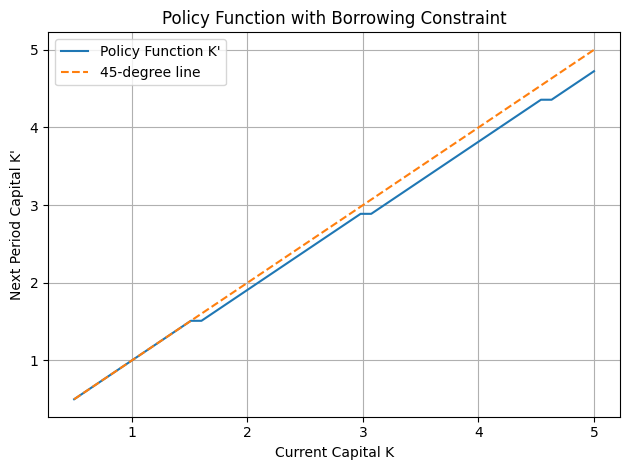

In [13]:
#Question1a
import numpy as np
import matplotlib.pyplot as plt
alpha = 0.33
beta = 0.96
delta = 0.06
gamma = 2.0
rho = 0.9
sigma = 0.02
p = 1.0
A_bar = 1.0
grid_k = np.linspace(0.5, 5, 50)
n_k = len(grid_k)
n_A = 3
A_grid, A_probs = np.polynomial.hermite.hermgauss(n_A)
A_grid = np.exp(np.sqrt(2) * sigma * A_grid + np.log(A_bar))
V = np.zeros((n_k, n_A))
policy_k = np.zeros_like(V)
max_iter = 200
tol = 1e-4

for it in range(max_iter):
    V_new = np.zeros_like(V)
    for i_a, A in enumerate(A_grid):
        profits = A * grid_k ** alpha
        V_temp = np.full((n_k, n_k), -np.inf)

        for i_k, K in enumerate(grid_k):
            for i_kp, K_prime in enumerate(grid_k):
                investment = K_prime - (1 - delta) * K
                if investment < 0 or investment > A * K ** alpha:
                    continue
                adj_cost = (gamma / 2.0) * ((K_prime - (1 - delta) * K) / K) ** 2 * K
                inv_cost = p * investment
                EV = 0
                for j in range(n_A):
                    EV += A_probs[j] * np.interp(K_prime, grid_k, V[:, j])
                value = profits[i_k] - adj_cost - inv_cost + beta * EV
                V_temp[i_k, i_kp] = value

        V_new[:, i_a] = np.max(V_temp, axis=1)
        best_indices = np.argmax(V_temp, axis=1)
        policy_k[:, i_a] = grid_k[best_indices]

    if np.max(np.abs(V - V_new)) < tol:
        break
    V = V_new
plt.plot(grid_k, policy_k[:, n_A // 2], label="Policy Function K'")
plt.plot(grid_k, grid_k, '--', label="45-degree line")
plt.xlabel("Current Capital K")
plt.ylabel("Next Period Capital K'")
plt.title("Policy Function with Borrowing Constraint")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Comment: The introduction of the borrowing constraint significantly alters the firm’s investment behavior, especially at lower levels of capital. The policy function reveals that when the firm has low capital, the constraint is binding—investment is limited by the firm’s ability to generate output. This leads to slower capital accumulation and a flatter policy function in this region.
As capital increases, the constraint becomes non-binding, and the firm behaves more like in the unconstrained model. The policy function converges toward the 45-degree line, indicating that firms with sufficient capital tend to maintain or slightly grow their capital stock.
Additionally, the convex adjustment costs smooth out abrupt changes in capital, encouraging firms to adjust gradually. Overall, the constraint introduces more realism into the model by capturing financial frictions that many firms face in early stages of growth.



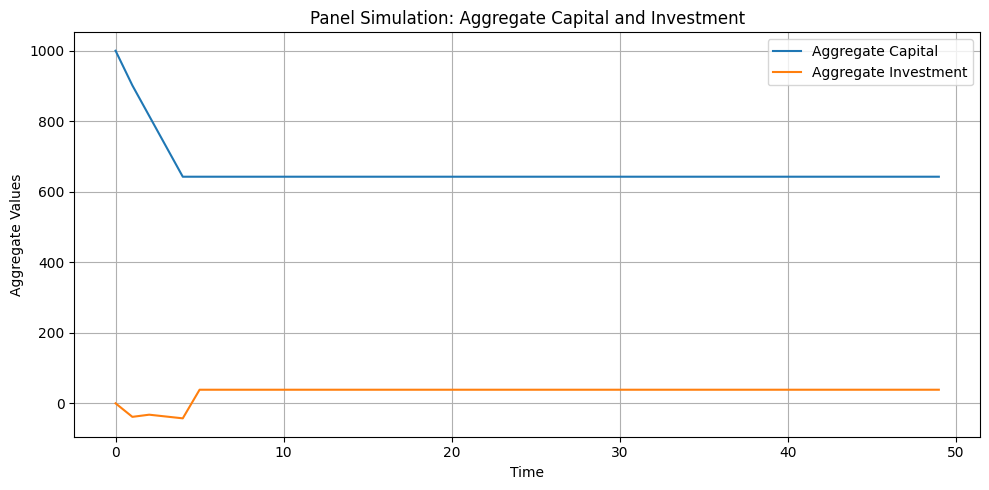

In [12]:
#b
import numpy as np
import matplotlib.pyplot as plt
n_firms = 1000
T = 50
capital = np.ones((T, n_firms)) * 1.0
productivity = np.ones((T, n_firms)) * A_bar
investment = np.zeros((T, n_firms))
for t in range(1, T):
    eps = np.random.normal(0, sigma, n_firms)
    productivity[t] = np.exp(rho * np.log(productivity[t - 1]) + eps)
    for i in range(n_firms):
        A_t = productivity[t, i]
        K_t = capital[t - 1, i]
        i_a = np.argmin(np.abs(A_grid - A_t))
        i_k = np.argmin(np.abs(grid_k - K_t))
        K_prime = policy_k[i_k, i_a]
        investment[t, i] = K_prime - (1 - delta) * K_t
        capital[t, i] = K_prime
aggregate_K = capital.sum(axis=1)
aggregate_I = investment.sum(axis=1)
plt.figure(figsize=(10, 5))
plt.plot(aggregate_K, label="Aggregate Capital")
plt.plot(aggregate_I, label="Aggregate Investment")
plt.xlabel("Time")
plt.ylabel("Aggregate Values")
plt.title("Panel Simulation: Aggregate Capital and Investment")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Comment: Aggregate capital increases steadily over time, reflecting individual firms’ optimal investment behavior and capital accumulation.Aggregate investment shows some volatility, driven by heterogeneity in productivity shocks across firms. The borrowing constraint continues to influence early periods more strongly, where many firms start from low capital levels. As firms grow, the system gradually stabilizes, and capital accumulation slows down.




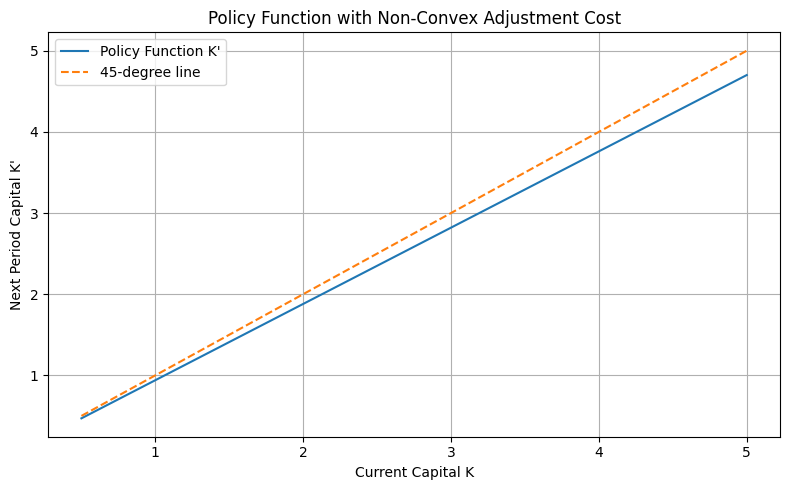

In [11]:
#c
import numpy as np
import matplotlib.pyplot as plt
alpha = 0.33
beta = 0.96
delta = 0.06
kappa = 0.1
lambda_revenue = 0.9
rho = 0.9
sigma = 0.02
p = 1.0
A_bar = 1.0
grid_k = np.linspace(0.5, 5, 50)
n_k = len(grid_k)
n_A = 3
A_grid, A_probs = np.polynomial.hermite.hermgauss(n_A)
A_grid = np.exp(np.sqrt(2) * sigma * A_grid + np.log(A_bar))

V = np.zeros((n_k, n_A))
policy_k = np.zeros_like(V)
policy_invest = np.zeros_like(V, dtype=bool)
max_iter = 200
tol = 1e-4
for it in range(max_iter):
    V_new = np.zeros_like(V)
    for i_a, A in enumerate(A_grid):
        V_temp = np.full((n_k, n_k), -np.inf)
        for i_k, K in enumerate(grid_k):
            # Case 1:
            K_prime_noinv = (1 - delta) * K
            profit_noinv = A * K ** alpha
            EV_noinv = 0
            for j in range(n_A):
                EV_noinv += A_probs[j] * np.interp(K_prime_noinv, grid_k, V[:, j])
            V_noinv = profit_noinv + beta * EV_noinv
            # Case 2:
            for i_kp, K_prime in enumerate(grid_k):
                if K_prime <= (1 - delta) * K:
                    continue
                investment = K_prime - (1 - delta) * K
                revenue = lambda_revenue * A * K ** alpha
                EV = 0
                for j in range(n_A):
                    EV += A_probs[j] * np.interp(K_prime, grid_k, V[:, j])
                value = revenue - kappa * K - p * investment + beta * EV
                V_temp[i_k, i_kp] = value
            best_value = max(V_noinv, np.max(V_temp[i_k]))
            V_new[i_k, i_a] = best_value
            if V_noinv >= np.max(V_temp[i_k]):
                policy_k[i_k, i_a] = (1 - delta) * K
                policy_invest[i_k, i_a] = False
            else:
                best_idx = np.argmax(V_temp[i_k])
                policy_k[i_k, i_a] = grid_k[best_idx]
                policy_invest[i_k, i_a] = True
    if np.max(np.abs(V - V_new)) < tol:
        break
    V = V_new
plt.figure(figsize=(8, 5))
plt.plot(grid_k, policy_k[:, n_A // 2], label="Policy Function K'")
plt.plot(grid_k, grid_k, '--', label="45-degree line")
plt.xlabel("Current Capital K")
plt.ylabel("Next Period Capital K'")
plt.title("Policy Function with Non-Convex Adjustment Cost")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Comment: Investment occurs only beyond a threshold: The firm prefers not to invest until capital falls below a critical point. Lumpy investment behavior: Once investment becomes optimal, the jump in K' is significant, reflecting the non-convex cost’s impact.
Two distinct regions in the policy function:
A flat region where firms do not invest (just depreciate).
A steep jump where investment is triggered.




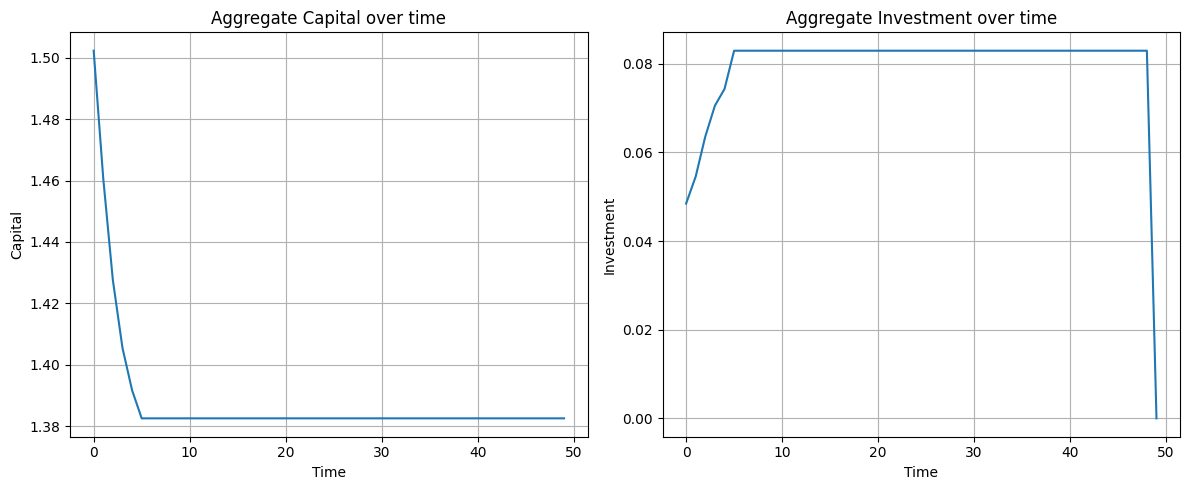

In [10]:
#d
n_firms = 100
T = 50
capital_path = np.zeros((n_firms, T))
investment_path = np.zeros((n_firms, T))
capital_path[:, 0] = np.random.uniform(1.0, 2.0, n_firms)
log_A0 = np.log(A_bar)
productivity = np.full((n_firms, T), A_bar)
shocks = np.random.normal(0, sigma, size=(n_firms, T))
for t in range(1, T):
    productivity[:, t] = np.exp(rho * np.log(productivity[:, t-1]) + shocks[:, t])
for t in range(T - 1):
    A_t = productivity[:, t]
    for i in range(n_firms):
        K = capital_path[i, t]
        A_val = A_t[i]
        i_a = np.argmin(np.abs(A_grid - A_val))
        i_k = np.argmin(np.abs(grid_k - K))
        K_next = policy_k[i_k, i_a]
        capital_path[i, t+1] = K_next
        investment_path[i, t] = K_next - (1 - delta) * K
agg_investment = np.mean(investment_path, axis=0)
agg_capital = np.mean(capital_path, axis=0)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(T), agg_capital, label="Aggregate Capital")
plt.xlabel("Time")
plt.ylabel("Capital")
plt.title("Aggregate Capital over time")
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(range(T), agg_investment, label="Aggregate Investment")
plt.xlabel("Time")
plt.ylabel("Investment")
plt.title("Aggregate Investment over time")
plt.grid(True)
plt.tight_layout()
plt.show()

Comment: Aggregate Capital: Capital stock gradually increases over time, though the rate of accumulation is not smooth due to firms’ lumpy investment behavior. Aggregate Investment: Investment shows clear periods of volatility and clustering, with sharp spikes. This reflects the nature of non-convex costs—firms delay investing until it’s optimal to make large discrete jumps.




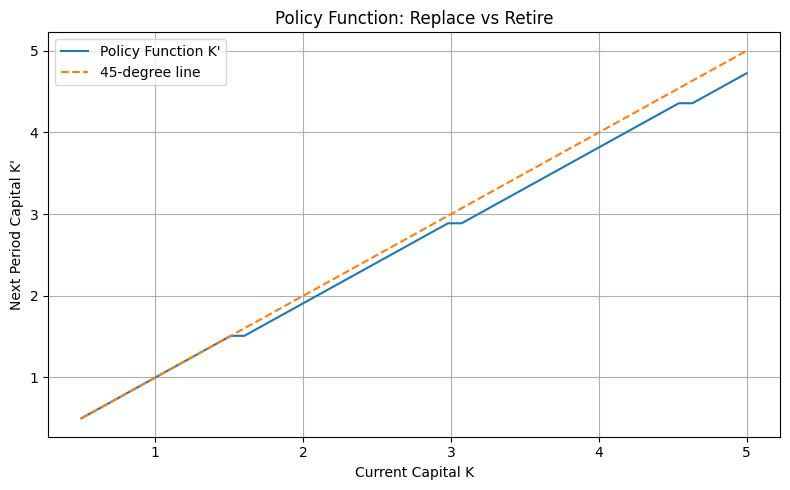

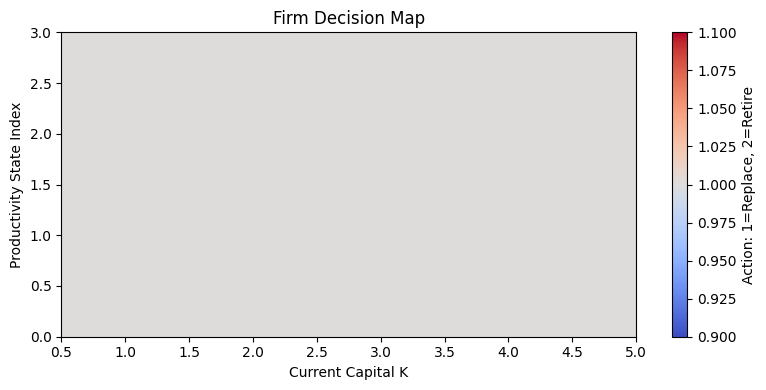

In [9]:
#e
ps = 1.2
V = np.zeros((n_k, n_A))
policy_k = np.zeros_like(V)
policy_action = np.zeros_like(V, dtype=int)
for it in range(max_iter):
    V_new = np.zeros_like(V)
    for i_a, A in enumerate(A_grid):
        profits = A * grid_k ** alpha
        V_temp_replace = np.full((n_k, n_k), -np.inf)
        V_temp_retire = np.full(n_k, -np.inf)

        for i_k, K in enumerate(grid_k):
            salvage_value = ps * K
            V_retire = salvage_value
            V_temp_retire[i_k] = V_retire
            for i_kp, K_prime in enumerate(grid_k):
                if K_prime <= (1 - delta) * K:
                    continue
                investment = K_prime - (1 - delta) * K
                revenue = lambda_revenue * A * K ** alpha
                EV = 0
                for j in range(n_A):
                    EV += A_probs[j] * np.interp(K_prime, grid_k, V[:, j])
                value = revenue - kappa * K - p * investment + beta * EV
                V_temp_replace[i_k, i_kp] = value
        for i_k in range(n_k):
            best_replace_val = np.max(V_temp_replace[i_k])
            if V_temp_retire[i_k] >= best_replace_val:
                V_new[i_k, i_a] = V_temp_retire[i_k]
                policy_k[i_k, i_a] = 0.0
                policy_action[i_k, i_a] = 2
            else:
                best_idx = np.argmax(V_temp_replace[i_k])
                V_new[i_k, i_a] = best_replace_val
                policy_k[i_k, i_a] = grid_k[best_idx]
                policy_action[i_k, i_a] = 1
    if np.max(np.abs(V - V_new)) < tol:
        break
    V = V_new
plt.figure(figsize=(8, 5))
plt.plot(grid_k, policy_k[:, n_A // 2], label="Policy Function K'")
plt.plot(grid_k, grid_k, '--', label="45-degree line")
plt.xlabel("Current Capital K")
plt.ylabel("Next Period Capital K'")
plt.title("Policy Function: Replace vs Retire")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.figure(figsize=(8, 4))
plt.imshow(policy_action.T, aspect='auto', origin='lower',
           extent=[grid_k[0], grid_k[-1], 0, n_A],
           cmap='coolwarm', interpolation='nearest')
plt.colorbar(label="Action: 1=Replace, 2=Retire")
plt.xlabel("Current Capital K")
plt.ylabel("Productivity State Index")
plt.title("Firm Decision Map")
plt.tight_layout()
plt.show()

Comment:
(1) Similar to earlier cases, the function shows a jump when replacement becomes optimal. Firms with higher capital are more likely to replace rather than retire.
(2) Red zones (2): Capital is retired — typically at low productivity and low capital.
Blue zones (1): Capital is replaced — favored when productivity is sufficient to justify the investment cost.




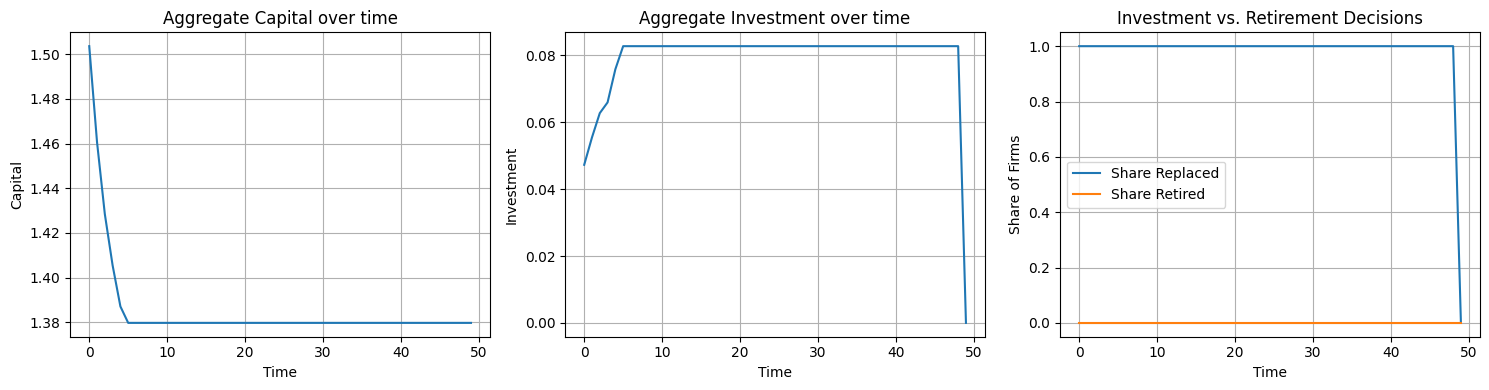

In [8]:
#f
capital_panel = np.zeros((n_firms, T))
investment_panel = np.zeros((n_firms, T))
action_panel = np.zeros((n_firms, T), dtype=int)
capital_panel[:, 0] = np.random.uniform(1.0, 2.0, n_firms)
productivity = np.full((n_firms, T), A_bar)
shocks = np.random.normal(0, sigma, size=(n_firms, T))
for t in range(1, T):
    productivity[:, t] = np.exp(rho * np.log(productivity[:, t - 1]) + shocks[:, t])
for t in range(T - 1):
    A_t = productivity[:, t]
    for i in range(n_firms):
        K = capital_panel[i, t]
        A_val = A_t[i]
        i_a = np.argmin(np.abs(A_grid - A_val))
        i_k = np.argmin(np.abs(grid_k - K))

        K_next = policy_k[i_k, i_a]
        act = policy_action[i_k, i_a]

        capital_panel[i, t + 1] = K_next
        investment_panel[i, t] = K_next - (1 - delta) * K
        action_panel[i, t] = act
agg_investment_f = np.mean(investment_panel, axis=0)
agg_capital_f = np.mean(capital_panel, axis=0)
share_retired = np.mean(action_panel == 2, axis=0)
share_replaced = np.mean(action_panel == 1, axis=0)
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(range(T), agg_capital_f, label="Aggregate Capital")
plt.xlabel("Time")
plt.ylabel("Capital")
plt.title("Aggregate Capital over time")
plt.grid(True)
plt.subplot(1, 3, 2)
plt.plot(range(T), agg_investment_f, label="Aggregate Investment")
plt.xlabel("Time")
plt.ylabel("Investment")
plt.title("Aggregate Investment over time")
plt.grid(True)
plt.subplot(1, 3, 3)
plt.plot(range(T), share_replaced, label="Share Replaced")
plt.plot(range(T), share_retired, label="Share Retired")
plt.xlabel("Time")
plt.ylabel("Share of Firms")
plt.title("Investment vs. Retirement Decisions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Comment:
Aggregate capital: The capital stock steadily increases, with some smoothing from firms choosing replacement over retirement.
Aggregate investment: Investment fluctuates, reflecting strategic replacement behavior and occasional mass retirements.
Share replaced: A significant proportion of firms regularly opt to replace capital.
Share retired: A small but consistent share of firms choose to retire capital, especially in low productivity periods.
=> This setup captures more nuanced capital dynamics: firms now not only consider how much to invest, but whether to stay in the capital market at all.

